# NLP Lab Task — Preprocessing to Deployment with Twitter Sentiment Dataset

## Overview

This lab takes students through the **entire NLP pipeline** using a **Twitter Sentiment Analysis dataset** (tweets labeled as positive, negative, or neutral). Students will preprocess the data, represent it using multiple methods, train classical machine learning models, evaluate their results, and finally build a small API for deployment.

---

## Learning Objectives

* Apply text preprocessing (regex, case folding, tokenization, stopword removal, punctuation handling).
* Compare stemming and lemmatization, and use POS tagging to analyze counts of nouns, verbs, and adjectives.
* Build text representations using **Bag-of-Words**, **TF–IDF**, and **Word2Vec**.
* Train classical ML models inside an sklearn **Pipeline**.
* Evaluate models with standard metrics and perform basic error analysis.
* Save a trained pipeline and build a simple API to serve predictions.

---

## Dataset

We will use the **Sentiment140 Twitter dataset** (1.6M tweets, labeled positive/negative). For simplicity, you can work with a smaller balanced subset (e.g., 10k–20k tweets). This dataset is widely used for sentiment analysis and contains real, noisy text with mentions, hashtags, and emoticons.

Dataset link: [Sentiment140](http://help.sentiment140.com/for-students/)

---

## Step-by-Step Tasks

### 1) Exploratory Data Analysis (EDA)

* Load dataset, show class distribution, tweet length histogram, and a few sample tweets.
* Deliverable: 3 plots (class balance, length histogram, top frequent tokens) + 5 example tweets.

### 2) Regex Cleaning

* Remove URLs, mentions (@user), hashtags, emojis (or replace with tokens), and extra whitespace.
* Show a before-and-after example for at least 3 tweets.

### 3) Case Folding & Tokenization

* Convert all text to lowercase.
* Tokenize tweets using NLTK or spaCy.
* Compare vocabulary size before and after cleaning.

### 4) Stopwords, Punctuation, and Numbers

* Remove stopwords (with NLTK list, customizable).
* Decide how to handle punctuation and numbers (remove or replace with `<NUM>`).
* Deliverable: short explanation of your choice.

### 5) Stemming vs Lemmatization

* Use PorterStemmer (stemming) and spaCy lemmatizer.
* Show 20 sample words with their stem vs lemma.
* Train quick models with both and compare results.

### 6) POS Tagging (extra features)

* Use spaCy to count nouns, verbs, and adjectives per tweet.
* Add these counts as additional numeric features.
* Compare model with vs without POS features.

### 7) Text Representation

* Implement three representations:
  1. **Bag-of-Words** (CountVectorizer)
  2. **TF–IDF** (TfidfVectorizer)
  3. **Word2Vec** (pretrained embeddings, averaged per tweet)
* Compare vocabulary sizes and representation dimensions.

### 8) Modeling with Pipelines

* Use sklearn Pipelines to connect preprocessing + vectorizer + classifier.
* Models to try:
  * Multinomial Naive Bayes (for BoW/TF–IDF)
  * Logistic Regression
  * Linear SVM
* Deliverable: comparison table (accuracy, F1-score).

### 9) Evaluation & Error Analysis

* Use held-out test set.
* Metrics: accuracy, precision, recall, F1, confusion matrix.
* Show 10 misclassified tweets and discuss why they may be difficult.

### 10) Save Model Pipeline

* Save the best pipeline using `joblib` or `pickle`.
* Deliverable: `sentiment_model.pkl` file.

### 11) Build a Simple API (Deployment Step)

* Create a small Flask API with one endpoint `/predict` that accepts a tweet as input and returns sentiment prediction.
* The API should load the saved pipeline and make predictions.
* Deliverable: `app.py` with Flask code + test with a sample curl or Postman request.

---

## Deliverables

1. Jupyter Notebook with step-by-step tasks, results, and code.
2. Comparison tables for preprocessing choices and representations.
3. Saved pipeline file (`.pkl`).
4. Flask API script (`app.py`).
5. Short report in markdown cell summarizing preprocessing, modeling choices, and results.

---

This streamlined lab ensures students get hands-on experience with **real-world text preprocessing, classical modeling, and deployment of NLP systems**.


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Load the Dataset

We will use the **Sentiment140 Twitter Sentiment dataset**.  
It contains 1.6 million tweets labeled as positive (4) or negative (0).  
For this lab, we will load a smaller subset (e.g., 20,000 rows) for faster experimentation.

```python
import pandas as pd

# Column order for Sentiment140 dataset:
# 0 - target (0 = negative, 4 = positive)
# 1 - ids
# 2 - date
# 3 - flag
# 4 - user
# 5 - text (tweet)

# Update the file path if needed
file_path = "sentiment140.csv"

# Load with proper encoding
df = pd.read_csv(file_path, encoding='latin-1', header=None)

# Assign column names
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map target labels: 0 → negative, 4 → positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Take a smaller sample for experiments (optional)
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Quick check
print(df.shape)
df.head()


In [1]:
import pandas as pd

import pandas as pd
import zipfile
import os
import requests

# Step 1: Download the dataset (if not already downloaded)
url = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
zip_path = "trainingandtestdata.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)

# Step 2: Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Step 3: Load training data
file_path = "training.1600000.processed.noemoticon.csv"

df = pd.read_csv(file_path, encoding="latin-1", header=None)
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map sentiment labels: 0 = negative, 4 = positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Optional: sample a smaller dataset for quicker experiments
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Preview the data
print(df.shape)
df.head()


# Load training set
train_path = "training.1600000.processed.noemoticon.csv"
train_df = pd.read_csv(train_path, encoding="latin-1", header=None)
train_df.columns = ["target", "id", "date", "flag", "user", "text"]
train_df["target"] = train_df["target"].map({0: "negative", 4: "positive"})

print("Training set:", train_df.shape)
print(train_df.head())

# Load manual test set
test_path = "testdata.manual.2009.06.14.csv"
test_df = pd.read_csv(test_path, encoding="latin-1", header=None)
test_df.columns = ["target", "id", "date", "flag", "user", "text"]

# This test set has labels 0 (negative), 2 (neutral), 4 (positive)
test_df["target"] = test_df["target"].map({0: "negative", 2: "neutral", 4: "positive"})

print("Test set:", test_df.shape)
print(test_df.head())


(20000, 6)
Training set: (1600000, 6)
     target          id                          date      flag  \
0  negative  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1  negative  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2  negative  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3  negative  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4  negative  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Test set: (498, 6)
     target  id                          date     flag      user  \
0  positive   3  Mon May 11 03:17:40 UTC

## EDA

In [4]:
train_df["target"].value_counts()

target
negative    800000
positive    800000
Name: count, dtype: int64

In [3]:
test_df["target"].value_counts()

target
positive    182
negative    177
neutral     139
Name: count, dtype: int64

In [7]:
df_with_lengths = train_df[["text","target"]].copy()
df_with_lengths["length"] = train_df["text"].str.len()

print(df_with_lengths.head())

                                                text    target  length
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  negative     115
1  is upset that he can't update his Facebook by ...  negative     111
2  @Kenichan I dived many times for the ball. Man...  negative      89
3    my whole body feels itchy and like its on fire   negative      47
4  @nationwideclass no, it's not behaving at all....  negative     111


Text(0.5, 1.0, 'Distribution of Tweet Lengths by Sentiment')

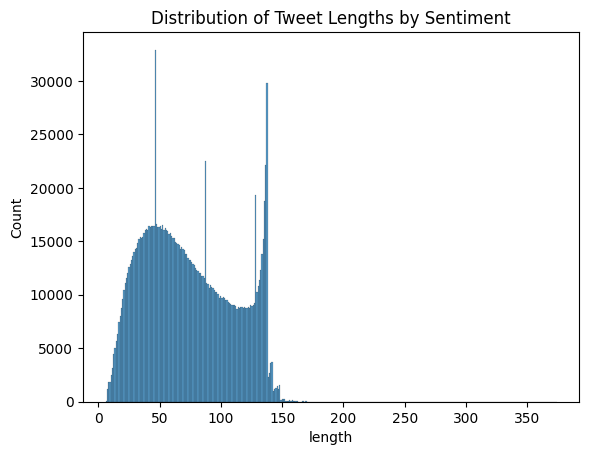

In [13]:
sns.histplot(data=df_with_lengths, x="length")
plt.title("Distribution of Tweet Lengths by Sentiment")

In [14]:
df_with_lengths["length"].describe()

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: length, dtype: float64

In [15]:
df_with_lengths.groupby("target")["length"].mean()

target
negative    74.301790
positive    73.878433
Name: length, dtype: float64

In [33]:
df_with_lengths[df_with_lengths["length"] >150]["text"].head(10)

1767     tks pa 4 &quot;tapauing&quot; croissant tuna k...
3434     @danielhcwong Taylor 814ce --&gt; #&amp;$(#&am...
6894     Woke up early this morning to &quot;not all th...
13538    Took niece &amp; nephew to Blockbuster- rented...
16809    @SongzYuuup wat is the name of ur mixtape with...
17007    Tanned and had dinner with my Dad. Now TWO Joh...
19818    I don't like it when people use the word &quot...
20666    &quot;Now is no time 2go headlong in2 a diffic...
21867     i love u bro. thanks for all the memories:sar...
23088    @jeffpulver sayin' &quot;hi&quot;. Still upset...
Name: text, dtype: object

In [34]:

for i in range(30):
    long_tweet = df_with_lengths[df_with_lengths["length"] > 150]["text"].head(50).iloc[i]
    print(long_tweet)


tks pa 4 &quot;tapauing&quot; croissant tuna knowing dat Ive back-to-back meetings since morning  &amp; Zuraidah tks 4 buying my FAV STARBUCK MOCHA FRAP
@danielhcwong Taylor 814ce --&gt; #&amp;$(#&amp;$!(@#$(!@#*$(#!( sweet mother of #@&amp;$(!@#($*(!@#*$(!@#&amp;$(!@#$&amp;!(@#!#@($... my livie is only 2900 
Woke up early this morning to &quot;not all the way better&quot; baby and a &quot;I think I'm sick Aaron&quot; wife. When these powers are combined! Not good 
Took niece &amp; nephew to Blockbuster- rented &quot;Marley&amp;me&quot;, &amp; &quot;Slumdog Millionaire&quot; Niece kiki799 reinjured ankle @ last night b-ball game 
@SongzYuuup wat is the name of ur mixtape with &quot;r u a performer&quot; &amp; &quot;do u kno what la pearla is&quot; i lost all my music and i ? that mixtape 
Tanned and had dinner with my Dad. Now TWO John Cusack 80's films. &quot;The Sure Thing&quot; &amp; &quot;One Crazy Summer&quot; All that is missing is my BFFF 
I don't like it when people use the wor

From my analysis so far, I can conclude that the main text patterns to handle during preprocessing are:

- Links/URLs 

- Dates 

- Numbers/digits 

- Mentions and usernames => @ -----

- HTML entities => Transform them back to their real characters  (&gt)  then remove 
   -  => html.unescape(text)

#### top frequent tokens before preprocessing

In [45]:
from collections import Counter
import re


all_words = " ".join(df["text"]).lower()


tokens = re.findall(r'\b\w+\b', all_words)


top_tokens = Counter(tokens).most_common(20)
print(top_tokens)


[('i', 11811), ('to', 7092), ('the', 6570), ('a', 4881), ('my', 3919), ('you', 3882), ('it', 3784), ('and', 3769), ('is', 2931), ('for', 2735), ('in', 2656), ('s', 2288), ('t', 2262), ('of', 2161), ('on', 2107), ('me', 2037), ('that', 2032), ('so', 1860), ('have', 1792), ('m', 1739)]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'i'),
  Text(1, 0, 'to'),
  Text(2, 0, 'the'),
  Text(3, 0, 'a'),
  Text(4, 0, 'my'),
  Text(5, 0, 'you'),
  Text(6, 0, 'it'),
  Text(7, 0, 'and'),
  Text(8, 0, 'is'),
  Text(9, 0, 'for'),
  Text(10, 0, 'in'),
  Text(11, 0, 's'),
  Text(12, 0, 't'),
  Text(13, 0, 'of'),
  Text(14, 0, 'on'),
  Text(15, 0, 'me'),
  Text(16, 0, 'that'),
  Text(17, 0, 'so'),
  Text(18, 0, 'have'),
  Text(19, 0, 'm')])

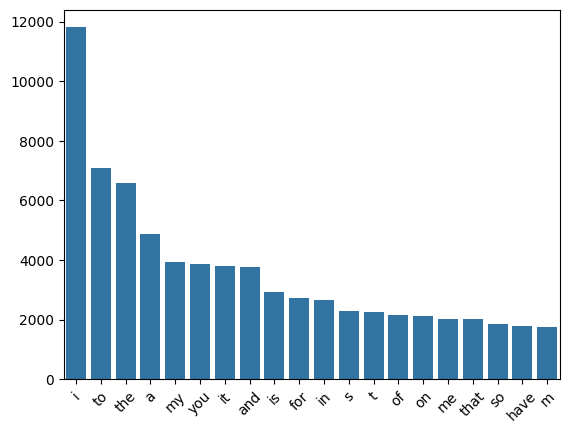

In [43]:
sns.barplot(x=[token[0] for token in top_tokens], y=[token[1] for token in top_tokens])
plt.xticks(rotation=45)

I used only df, a sample of the dataset (due to memory limitations). Almost all of the top 20 most frequent tokens turned out to be stopwords. Therefore, we should remove stopwords during preprocessing.

----

## Regex Cleaning

In [61]:
import html
def Regex_cleaning(text) :
    text = html.unescape(str(text))
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # remove URLs
    text = re.sub(r'\@\w+|\#','', text) # remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text) # remove special characters and punctuation
    text = re.sub(r'\s+', ' ', text).strip() # remove extra whitespace
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+', '', text) # remove emojis
    text = re.sub(r'\d+', '', text) # remove numbers
    return text

In [62]:
df_with_lengths["cleaned_text"] = df_with_lengths["text"].apply(Regex_cleaning)


In [63]:
df_with_lengths[["text","cleaned_text"]]

,text,cleaned_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",A thats a bummer You shoulda got David Carr of...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...
...,...,...
1599995,Just woke up. Having no school is the best fee...,Just woke up Having no school is the best feel...
1599996,TheWDB.com - Very cool to hear old Walt interv...,TheWDBcom Very cool to hear old Walt interviews
1599997,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover Ask me fo...
1599998,Happy 38th Birthday to my boo of alll time!!! ...,Happy th Birthday to my boo of alll time Tupac...


In [64]:
y=df_with_lengths[["text","cleaned_text"]].iloc[1599999]
print(y['text'])
print(y['cleaned_text'])

happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H 
happy charitytuesday


----